This notebook contains a PyTorch implementation for the paper "Solving stochastic differential equations and Kolmogorov equations by means of deep learning" by Christian Beck et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
# Honestly though I wanted to do this with JAX+STAX (or FLAX if I really had the guts to use a 3 month old library)

In [ ]:
# Fully connected neural network
# Normalize inputs
# Xavier initialization
# Batch normalization + parameters
# Batch gradient descent 
# Sample uniformly from [a,b]^d
# Adam optimizer

# Computing approximate L1/L2 error

# Sampling from Ito diffusion X_t^x with mu, sigma given center x

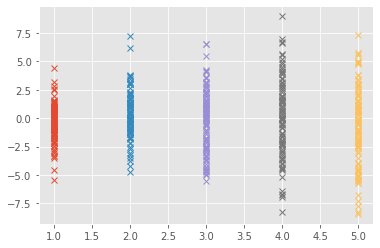

10


In [2]:
class ItoDiffusion:
    def __init__(self, mu, sigma, N):
        # Initializing the Ito Diffusion
        # mu    :: R^dxJ -> R^dxJ
        # sigma :: R^dxJ -> R^dxdxJ
        # where J is the batch size
        # N :: Int (Number of points in discretization)
        self.mu = mu
        self.sigma = sigma
        self.N = N
    
    def sample(self, x, T):
        # Generate J samples of X_T^x
        # x :: R^dxJ
        dt        = T/self.N
        self.d    = x.size(0)
        batchsize = x.size(1)
        for i in range(self.N):
            x = x + self.mu(x)*dt + self.sigma(x)*mvn(torch.zeros(self.d), dt*torch.eye(self.d)).sample([batchsize]).T
        return x
    
brownian_motion = ItoDiffusion(lambda x: torch.zeros(x.size(0),x.size(1)), lambda x: torch.sqrt(torch.tensor(2.0)), 1)


plot1=brownian_motion.sample(torch.randn(10,100),1)
plot2=brownian_motion.sample(torch.randn(10,100),2)
plot3=brownian_motion.sample(torch.randn(10,100),3)
plot4=brownian_motion.sample(torch.randn(10,100),4)
plot5=brownian_motion.sample(torch.randn(10,100),5)
plt.plot(torch.ones(100),plot1[0,:],'x',2*torch.ones(100),plot2[0,:],'x',3*torch.ones(100),plot3[0,:],'x',4*torch.ones(100),plot4[0,:],'x',5*torch.ones(100),plot5[0,:],'x')
plt.show()
print(brownian_motion.d)

In [4]:
class FCNN(nn.Module):
    # initializ parameters
    # input norm
    # batch norm
    
    def __init__(self, dim, hidden_layers):
        # dim    :: Int (Input dimension and also neurons in each hidden layer)
        # hidden :: Int (Number of hidden layers)
        super().__init__()
        self.hidden_layers = hidden_layers
        self.model = nn.Sequential()
        for i in range(self.hidden_layers):
            self.model.add_module("Hidden"+str(i), nn.Linear(dim,dim))
            self.model.add_module("Batch norm "+str(i),nn.BatchNorm1d(dim))
            self.model.add_module("Actvation "+str(i),nn.Tanh())
        self.model.add_module("Output",nn.Linear(dim,1))
        

    def forward(self,x):
        # x :: R^d (Spatial point)
        return self.model(x)
        # I know, this makes is harder to debug comparing to running the 
        # input through each layer separately

In [5]:
def Lp_rel_error(neural_net, exact_sol, a,b,d, N,p):
    # neural_net :: FCNN (instance of neural network)
    # exact_sol  :: RxR^d -> R (exact solution of the PDE)
    # a          :: Float (a in [a,b]^d)
    # b          :: Float (b in [a,b]^d)
    # d          :: Int (d in [a,b]^d)
    # N          :: Int (Number of points to sample in the MC estimate)
    # p          :: Int (p in the Lp)
    spatial_points = (a-b)*torch.rand(N,d) + b
    u_exact        = exact_sol(spatial_points).unsqueeze(0).T
    return float(torch.mean(torch.abs((neural_net(spatial_points) - u_exact)/u_exact).pow(p)))

In [ ]:
# Heat equation approximation
T,N   = 1,1      # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 0,1        # a,b in [a,b]^d
d   = 10         # d   in [a,b]^d
s   = 3          # total number of layers (including output, meaning we have s-1 hidden layers)
m   = 35000      # SGD iterations
J   = 8192
learning_rate = 0.001

# The Ito diffusion corresponding to the Heat equation is Brownian motion. Here we define the initial condition as 
# u(0,x)=||x||2 (squared Euclidean norm) and via an Ansatz you can get the exact solution as u(t,x) = ||x||2 + td
brownian_motion = ItoDiffusion(lambda x: torch.zeros(x.size(0),x.size(1)), lambda x: torch.sqrt(torch.tensor(2.0)), 1)
phi = lambda x: torch.norm(x,2,1)
u   = lambda x: phi(x) + T*d

model = FCNN(d,s-1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25000, gamma=0.1)

L1_errors = []
L2_errors = []

for i in range(m):
    optimizer.zero_grad()
    eta = (a-b)*torch.rand(J,d) + b
    X_N = brownian_motion.sample(eta,N)
    loss      = torch.mean(torch.norm(model(eta)-phi(X_N),2,1))
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i%100 == 0:
        L1_errors.append(Lp_rel_error(model, u, a,b,d, 1000,1))
        L2_errors.append(Lp_rel_error(model, u, a,b,d, 1000,2))
        print("Step {} L1 error is {}, L2 error is {} and loss function value is {}".format(i,L1_errors[-1],L2_errors[-1],loss))
        
        
plt.plot(range(len(L1_errors)),L1_errors)
plt.plot(range(len(L2_errors)),L2_errors)
plt.show()

Step 0 L1 error is 0.9817728400230408, L2 error is 0.9644933342933655 and loss function value is 417.9851989746094
Step 100 L1 error is 0.9506382942199707, L2 error is 0.9051052331924438 and loss function value is 386.05517578125
Step 200 L1 error is 0.8565602898597717, L2 error is 0.738254725933075 and loss function value is 292.8415832519531
Step 300 L1 error is 0.7566890716552734, L2 error is 0.5737833380699158 and loss function value is 198.2165985107422
Step 400 L1 error is 0.6791829466819763, L2 error is 0.4619431793689728 and loss function value is 134.18911743164062
Step 500 L1 error is 0.6223683953285217, L2 error is 0.3924160599708557 and loss function value is 100.75758361816406
